In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [23]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        #yscore = clf.predict_proba(Xte)
        #yscore = yscore[:,1]

        #accuracy on train set
        
        RMS=0
        for yp,yt in zip(ypred,y):
            RMS += ((yp - yt)**2)
        RMS = RMS / len(y)
        RMS = math.sqrt(RMS)
        
        RMS_all.append(RMS)
        
        groupres[model_name] = {'RMS':RMS_all}
        
        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [14]:
datadict = {'watch':{},'sensor':{}}
for freq in [50,45,40,35,30,25,20,15,10,5]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['watch'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)
for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[4:]:
        data = data[data[s]<np.finfo(np.float32).max]
    datadict['sensor'][freq] = data[(data.Subject != 1020) & (data.Subject != 1030)].reset_index(drop=True)

In [27]:
t1=time.time()
results = {}

for mode in ['watch','sensor']:
    
    results[mode] = {}

    for symptom in ['Tremor','Bradykinesia']:
        
        results[mode][symptom] = {}
        
        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = []
        
        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = pd.DataFrame()
        
        results[mode][symptom]['Regressor'] = {}
        regress_res_all = pd.DataFrame()
        regress_res_groups = pd.DataFrame()

        for freq in datadict[mode].keys():

            data = datadict[mode][freq]
            Data = data.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()]
            Data=Data.reset_index(drop=True) #reset index

            X = Data.iloc[:,5:].as_matrix()
            fnames = Data.iloc[:,5:].columns.values
            groups = Data.Subject.as_matrix()

            #Binary
            
            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups.append(res_group)
            
            results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
            results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            multi_res_groups = pd.concat((multi_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(multi_res_groups[multi_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest']
            R['Sampling Rate'] = [str(freq) + ' Hz']
            multi_res_all = pd.concat([multi_res_all,R])

            results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
            results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

            #Regressor

            y = Data[symptom].values.astype(int) #target 

            model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            regress_res_groups = pd.concat((regress_res_groups,res))
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
            R['Model'] = ['Random Forest'] 
            R['Sampling Rate'] = [str(freq) + ' Hz']
            regress_res_all = pd.concat([regress_res_all,R])

            results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
            results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Training Random Forest
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Training Random Forest
Elapsed time = 266.381 min


In [92]:
def barplotFreq(results,mode,symptom,classifier):
    if 'RMS' in results[mode][symptom][classifier]['res_groups']:
        groups = results[mode][symptom][classifier]['res_groups']['Sampling Rate']
        RMS = results[mode][symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[mode][symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
    else:
        groups = results[mode][symptom][classifier]['res_all']['Sampling Rate'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.title('Effect of Sampling Frequency on %s Model Performance: %s'%(classifier,symptom))
    
    print(results['watch']['Tremor']['Binary']['res_all'])

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


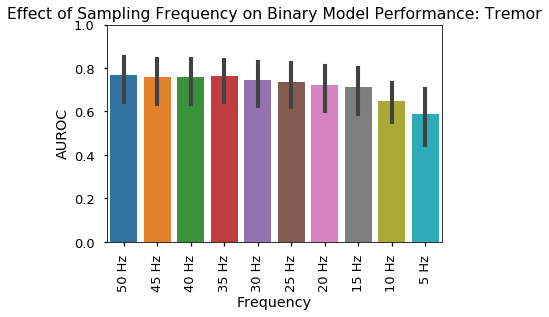

In [93]:
barplotFreq(results,'watch','Tremor','Binary')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


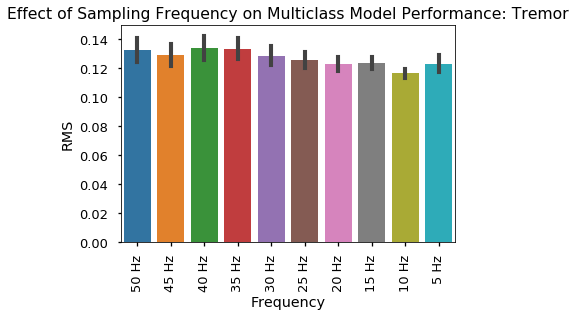

In [94]:
barplotFreq(results,'watch','Tremor','Multiclass')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


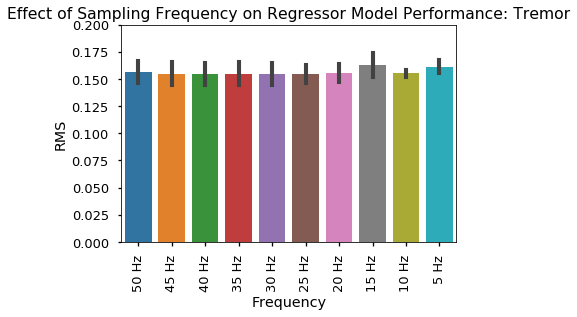

In [95]:
barplotFreq(results,'watch','Tremor','Regressor')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


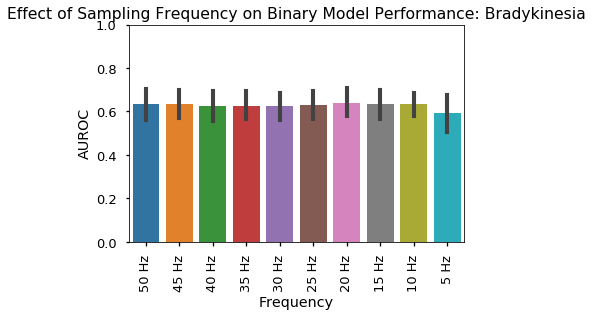

In [96]:
barplotFreq(results,'watch','Bradykinesia','Binary')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


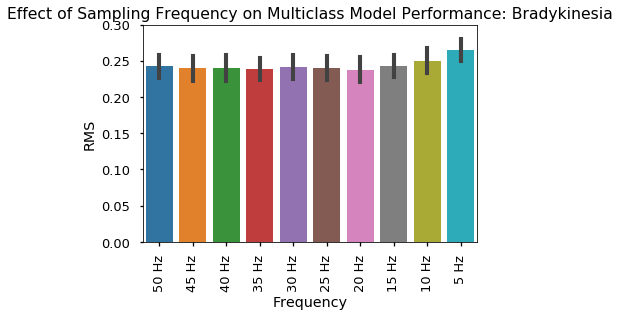

In [97]:
barplotFreq(results,'watch','Bradykinesia','Multiclass')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


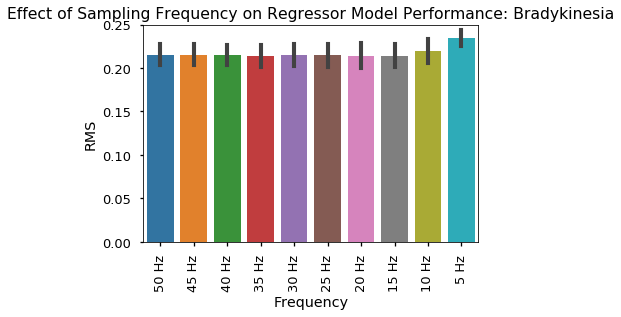

In [98]:
barplotFreq(results,'watch','Bradykinesia','Regressor')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


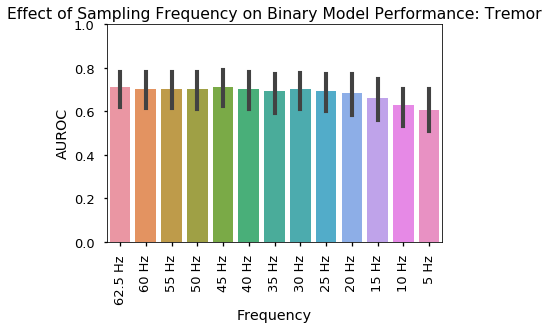

In [99]:
barplotFreq(results,'sensor','Tremor','Binary')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


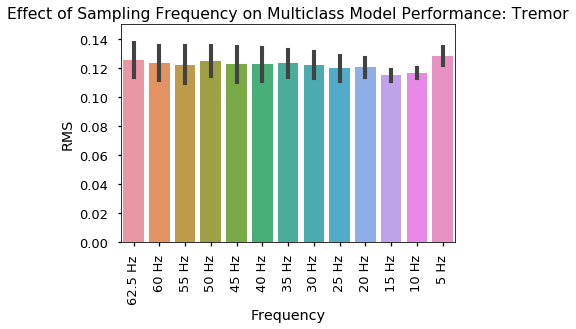

In [100]:
barplotFreq(results,'sensor','Tremor','Multiclass')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


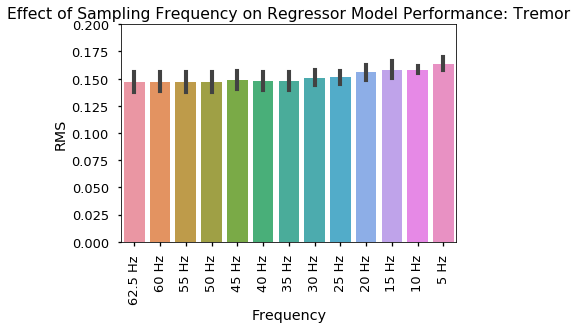

In [101]:
barplotFreq(results,'sensor','Tremor','Regressor')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


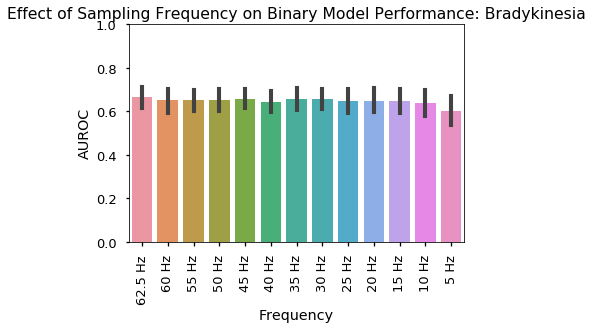

In [102]:
barplotFreq(results,'sensor','Bradykinesia','Binary')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


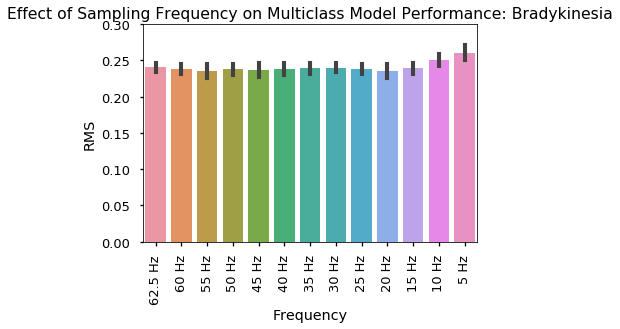

In [103]:
barplotFreq(results,'sensor','Bradykinesia','Multiclass')

      auprc     auroc        f1          model Sampling Rate
0  0.497454  0.767256  0.354482  Random Forest         50 Hz
1  0.497646  0.759243  0.344373  Random Forest         45 Hz
2  0.487468  0.759079  0.348926  Random Forest         40 Hz
3  0.486184  0.761320  0.341575  Random Forest         35 Hz
4  0.492203  0.744982  0.346192  Random Forest         30 Hz
5  0.485027  0.736416  0.350749  Random Forest         25 Hz
6  0.477007  0.722293  0.334649  Random Forest         20 Hz
7  0.473305  0.710828  0.312748  Random Forest         15 Hz
8  0.430888  0.646743  0.234675  Random Forest         10 Hz
9  0.468251  0.588833  0.222172  Random Forest          5 Hz


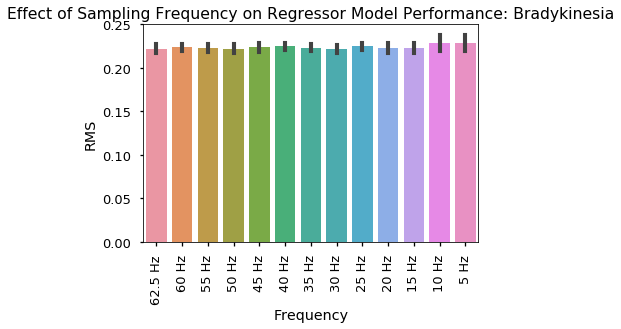

In [104]:
barplotFreq(results,'sensor','Bradykinesia','Regressor')